# <font color="red"> What was the highest performing pipeline and its corresponding ROC AUC score among the evaluated pipelines?

<font color="teal"> After evaluating the three pipelines on a smaller subset of the dataset, Pipeline 2 emerged as the preferred choice for the final pipeline. While Pipeline 1 achieved a respectable ROC AUC score of 0.8230, both Pipeline 2 and Pipeline 3 outperformed it significantly, with ROC AUC scores of 0.9127 and 0.9076, respectively. Despite Pipeline 3's incorporation of both tfidf and engineered features, Pipeline 2, which solely utilizes engineered features, demonstrated comparable performance. Moreover, Pipeline 2 offers the advantage of being considerably faster than Pipeline 3 due to its simpler feature set. Therefore, based on the analysis of model scores and efficiency, Pipeline 2 is selected as the final pipeline for further training and deployment.
</font>



In [ ]:
'''
+------------+--------------------+
| Pipeline   |   AUC Score (test) |
|------------|--------------------|
| Pipeline 1 |      0.8230        |
| Pipeline 2 |      0.9127        |
| Pipeline 3 |      0.9076        |
+------------+--------------------+
'''

# Running the best pipeline on 40% sampled data

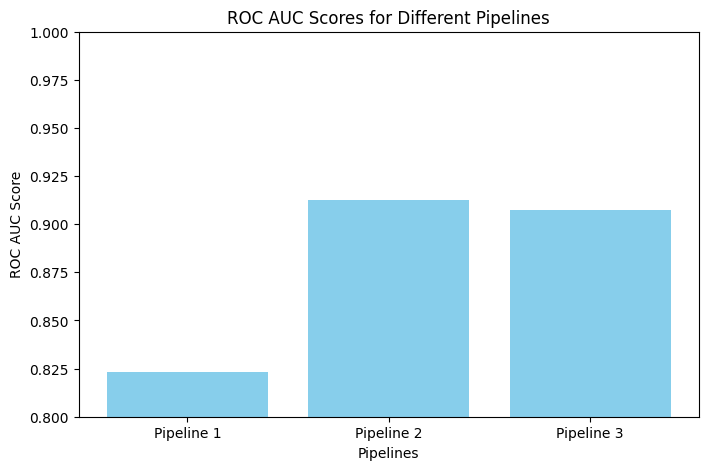

In [51]:
import matplotlib.pyplot as plt

# Pipeline names
pipelines = ['Pipeline 1', 'Pipeline 2', 'Pipeline 3']

# ROC AUC scores
roc_auc_scores = [0.8230, 0.9127, 0.9076]

# Plotting ROC AUC scores
plt.figure(figsize=(8, 5))
plt.bar(pipelines, roc_auc_scores, color='skyblue')
plt.title('ROC AUC Scores for Different Pipelines')
plt.xlabel('Pipelines')
plt.ylabel('ROC AUC Score on test data')
plt.ylim(0.8, 1.0)  # Limiting y-axis for better visualization
plt.show()

In [27]:
#Load Dataset
import pandas as pd
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [28]:
# Rename columns
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [29]:
#Convert to Binary if spam then 1, else 0 to process ahead
df['label'] = df['label'].map(lambda x: 1 if x == 'spam' else 0) # converting target labels to binary (0,1)

In [30]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from plot_learning_curve import plot_learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from FeaturizerSpacy import ManualFeatures
from sklearn.pipeline import Pipeline
import CustomPreprocessorSpacy as cp
from scipy.sparse import csr_matrix
from xgboost import XGBClassifier
from pathlib import Path
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [31]:
#Large subset sampling
df_ = df.sample(frac=0.4, replace=True, random_state=1)

In [32]:
#Extracting values of column message into X and label into Y, as numpy arrays
X, y = df_['message'].values, df_['label'].values

In [33]:
base_folder = Path('./')
data_folder = base_folder/'datasets/'
model_folder = base_folder/'models/'

model_folder.mkdir(exist_ok=True, parents=True)
data_folder.mkdir(exist_ok=True, parents=True)

In [34]:
# Splitting the data into train test splits with test as 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)

In [35]:
# Cleaning the text data in X_train and X_test
X_train_cleaned_basic = cp.SpacyPreprocessor(model='en_core_web_sm',
                                             lemmatize=False, lower=False,
                                             remove_stop=False, remove_punct=False,
                                             remove_email=False, remove_url=False,
                                             add_user_mention_prefix=False,
                                             basic_clean_only=True).transform(X_train)

X_test_cleaned_basic = cp.SpacyPreprocessor(model='en_core_web_sm',
                                            lemmatize=False, lower=False,
                                            remove_stop=False, remove_punct=False,
                                            remove_email=False, remove_url=False,
                                            add_user_mention_prefix=False,
                                            basic_clean_only=True).transform(X_test)

# save  this to a file
file_X_train_cleaned_basic = data_folder / 'x_train_cleaned_basic_small.pkl'
joblib.dump(X_train_cleaned_basic, file_X_train_cleaned_basic)

# save  this to a file
file_X_test_cleaned_basic = data_folder / 'x_test_cleaned_basic_small.pkl'
joblib.dump(X_test_cleaned_basic, file_X_test_cleaned_basic)

/content/CustomPreprocessorSpacy.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


['datasets/x_test_cleaned_basic_small.pkl']

In [36]:
#Using manual features
featurizer = ManualFeatures(spacy_model='en_core_web_sm', batch_size=1000)
X_train_cleaned_basic = joblib.load(file_X_train_cleaned_basic)
X_train_features, feature_names = featurizer.fit_transform(X_train_cleaned_basic)

In [39]:
pd.DataFrame(X_train_features, columns=feature_names).head()

,count_words,count_characters,count_characters_no_space,avg_word_length,count_numbers,count_sentences,noun_count,aux_count,verb_count,adj_count,ner
0,7.0,35.0,29.0,3.625000,0.0,1.0,1.0,1.0,2.0,0.0,1.0
1,14.0,67.0,55.0,3.666667,0.0,2.0,2.0,0.0,3.0,1.0,0.0
2,15.0,76.0,63.0,3.937500,1.0,2.0,4.0,2.0,2.0,1.0,1.0
3,20.0,88.0,70.0,3.333333,0.0,1.0,3.0,1.0,4.0,1.0,0.0
4,24.0,149.0,126.0,5.040000,3.0,1.0,8.0,1.0,2.0,0.0,1.0


In [40]:
#defining classifier and params grid
classifier_final = Pipeline([('classifier', XGBClassifier())])
params_classifier_final = {'classifier__n_estimators': [200, 400, 600, 800],
                       'classifier__max_depth': [1, 2, 3, 4]}

In [41]:
#Defining randomsearch CV
randomsearchCV_classifier_final = RandomizedSearchCV(estimator=classifier_final, param_distributions=params_classifier_final, cv=5, scoring='roc_auc')

In [42]:
#Fitting RandomSearchCV on train data
randomsearchCV_classifier_final.fit(X_train_features, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            grow_policy=None,
                                                            importance_type=None,
                                                            interaction_...
                                                            max_cat_to_onehot=None,
                                                            max_delta_step=None,
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=None, ...))]),
                   param_distributions={'classifier__max_depth': [1, 2, 3, 4],
                                        'classifier__n_estimators': [200, 400,
                                                                     600,
                                                                     800]},
                   scoring='roc_auc')

In [43]:
## let's check the cross validation score
print(f'Best cross-validation score: {randomsearchCV_classifier_final.best_score_:.2f}')
print("\nBest parameters: ", randomsearchCV_classifier_final.best_params_)
print("\nBest estimator: ", randomsearchCV_classifier_final.best_estimator_)

Best cross-validation score: 0.98

Best parameters:  {'classifier__n_estimators': 200, 'classifier__max_depth': 3}

Best estimator:  Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, miss

In [44]:
file_best_estimator_pipeline_final = model_folder / \
    'pipeline_final_best_estimator.pkl'
file_complete_grid_pipeline_final = model_folder / \
    'pipeline_final_complete_grid.pkl'

joblib.dump(randomsearchCV_classifier_final.best_estimator_,
            file_best_estimator_pipeline_final)
joblib.dump(randomsearchCV_classifier_final, file_complete_grid_pipeline_final)

# load the saved model
best_estimator_pipeline_final = joblib.load(file_best_estimator_pipeline_final)
complete_grid_pipeline_final = joblib.load(file_complete_grid_pipeline_final)

CPU times: user 193 ms, sys: 61.3 ms, total: 254 ms
Wall time: 3.88 s


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

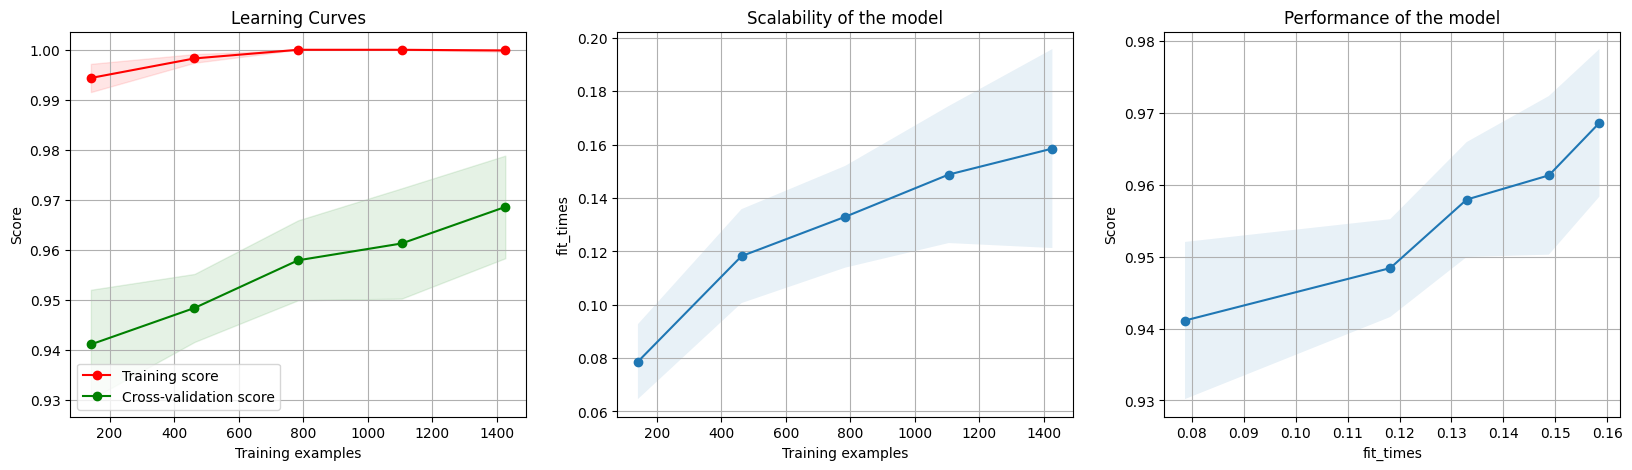

In [45]:
#Learning curves
%%time
plot_learning_curve(best_estimator_pipeline_final, 'Learning Curves',
                    X_train_features, y_train, n_jobs=-1)

In [46]:
# let's check the train scores
print(best_estimator_pipeline_final.score(X_train_features, y_train))

# let's check the cross validation score
print(complete_grid_pipeline_final.best_score_)

0.9994391475042064
0.9814274328094077


In [47]:
# Final Pipeline
def final_pipeline(text):
    text_cleaned = joblib.load(file_X_test_cleaned_basic)
    features, feature_names = featurizer.fit_transform(text_cleaned)
    best_estimator_pipeline_final = joblib.load(
        file_best_estimator_pipeline_final)
    predictions = best_estimator_pipeline_final.predict(features)
    return predictions

In [48]:
#Predicting on test values
y_test_pred = final_pipeline(X_test)

In [49]:
#Classification report on test data
print('\nTest set classification report:\n\n', classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.99      0.99      0.99       391
           1       0.93      0.91      0.92        55

    accuracy                           0.98       446
   macro avg       0.96      0.95      0.95       446
weighted avg       0.98      0.98      0.98       446



ROC AUC Score: 0.9494303650313881


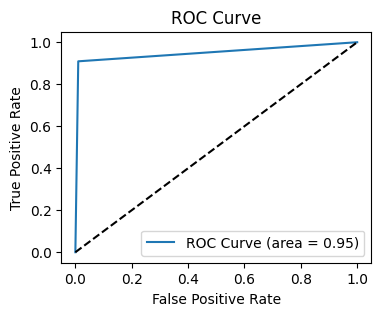

In [50]:
#ROC Score
roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"ROC AUC Score: {roc_auc}")

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

The final pipeline, trained and tested on 40% of the dataset, achieved an impressive ROC AUC score of 0.9494, indicating robust performance in classifying the data.